In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-15 04:22:24 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=10,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi.value)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
    model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
#     return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
#             sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
#     return (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total) \
#             == (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma)
    return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total))\
            == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma))            
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi.value)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi.value)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = False)

In [16]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma97                  yes
                   linear_system_scaling = none                  yes
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                               ma97_umax = 0.5                   yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20  

In [17]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

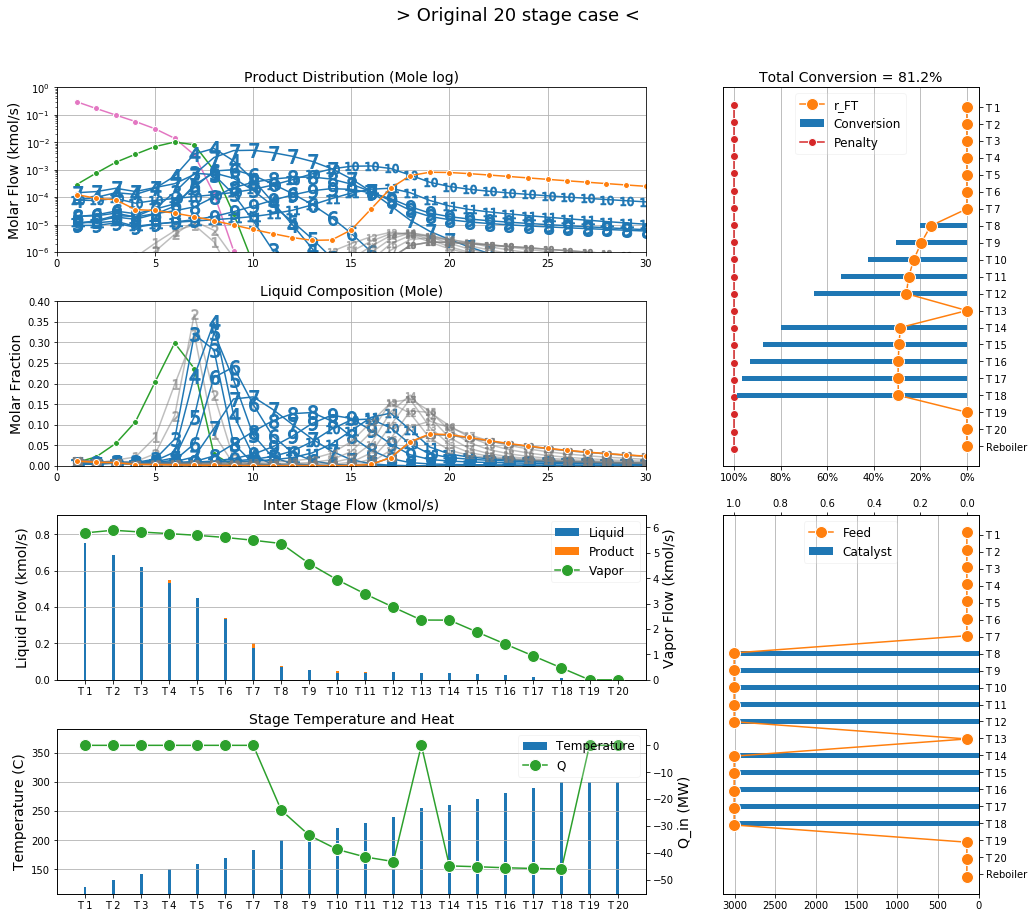

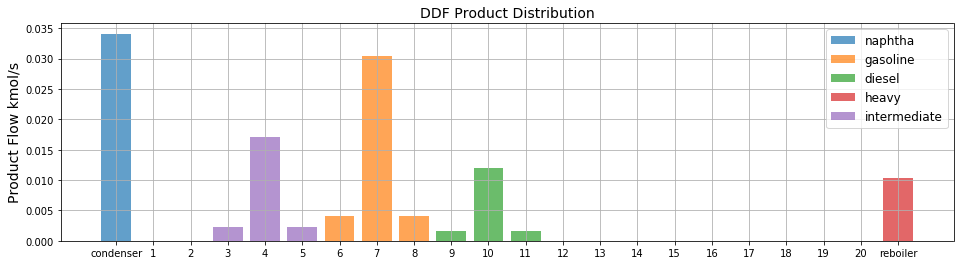

In [18]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [19]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [20]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [21]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [22]:
# iter_count = 0
# total_iter = 0
# meta_results = {}
# for i in model.component_data_objects(pe.Var,active=True):
#     if i.name.count('.') <= 1:
#         meta_results[i.name] = []
# meta_results['iter_count'] = []
# meta_results['total_iter'] = []

In [23]:
# while True:
#     iter_count += 2
#     total_iter += 2
#     opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = False)
#     model_tmp = deepcopy(model)
#     results = opt.solve(model_tmp,tee=False)

#     for i in meta_results.keys():
#         if i != 'iter_count' and i != 'total_iter':
#             meta_results[i].append(model_tmp.find_component(i).value)
#     meta_results['iter_count'].append(iter_count)
#     meta_results['total_iter'].append(total_iter)
    
#     print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
#     if results.solver.termination_condition.key == 'optimal':
#         break
        
# iter_count = 0
# model = deepcopy(model_tmp)

In [24]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma97                  yes
                   linear_system_scaling = none                  yes
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                               ma97_umax = 0.5                   yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20  

  56 -1.0026034e-01 1.36e+01 6.01e+03  -6.0 5.52e+02    -  4.71e-02 5.74e-01h  1
  57 -1.0049987e-01 2.31e+01 4.14e+03  -6.0 6.62e+03 -10.4 1.70e-02 2.03e-01h  2
  58 -1.0060708e-01 2.70e+01 4.13e+03  -6.0 1.28e+04    -  6.47e-02 4.92e-02h  1
  59 -1.0067933e-01 7.09e+00 2.24e+03  -6.0 7.17e+02    -  4.94e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.0060975e-01 1.51e+00 2.59e+02  -6.0 3.08e+01  -8.1 9.92e-01 7.87e-01h  1
  61 -1.0060430e-01 8.41e-02 1.02e-01  -6.0 3.12e+01  -8.6 1.00e+00 1.00e+00h  1
  62 -1.0067153e-01 6.72e-01 2.77e-01  -6.0 9.74e+01  -9.1 1.00e+00 8.75e-01h  1
  63 -1.0066694e-01 2.12e+00 1.40e+00  -6.0 4.02e+02    -  1.00e+00 1.00e+00h  1
  64 -1.0068521e-01 9.53e-01 2.03e+00  -6.0 2.37e+02    -  1.00e+00 7.32e-01h  1
  65 -1.0077318e-01 6.13e-01 1.27e+00  -6.0 2.08e+02    -  1.00e+00 7.98e-01h  1
  66 -1.0083119e-01 1.95e+00 9.01e+00  -6.0 1.09e+03    -  1.50e-02 3.22e-01h  2
  67 -1.0074067e-01 2.75e-01


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.03%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1386          0.9921  0.0871       2.3285

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.7  0.000       0.000  0.000  0.000  0.000       5.5466  0.0000  1.2312  0.0000       20.000
NON--[2]     149.7  0.000       0.000  0.000  0.000  0.000       5.7857  0.0000  1.1758  0.0000       20.000
NON--[3]     160.9  0.000       0.000  0.000  0.000  0.000       5.7303  0.0000  1.1268  0.0000       20.000
NON--[4]     170.0  0.00

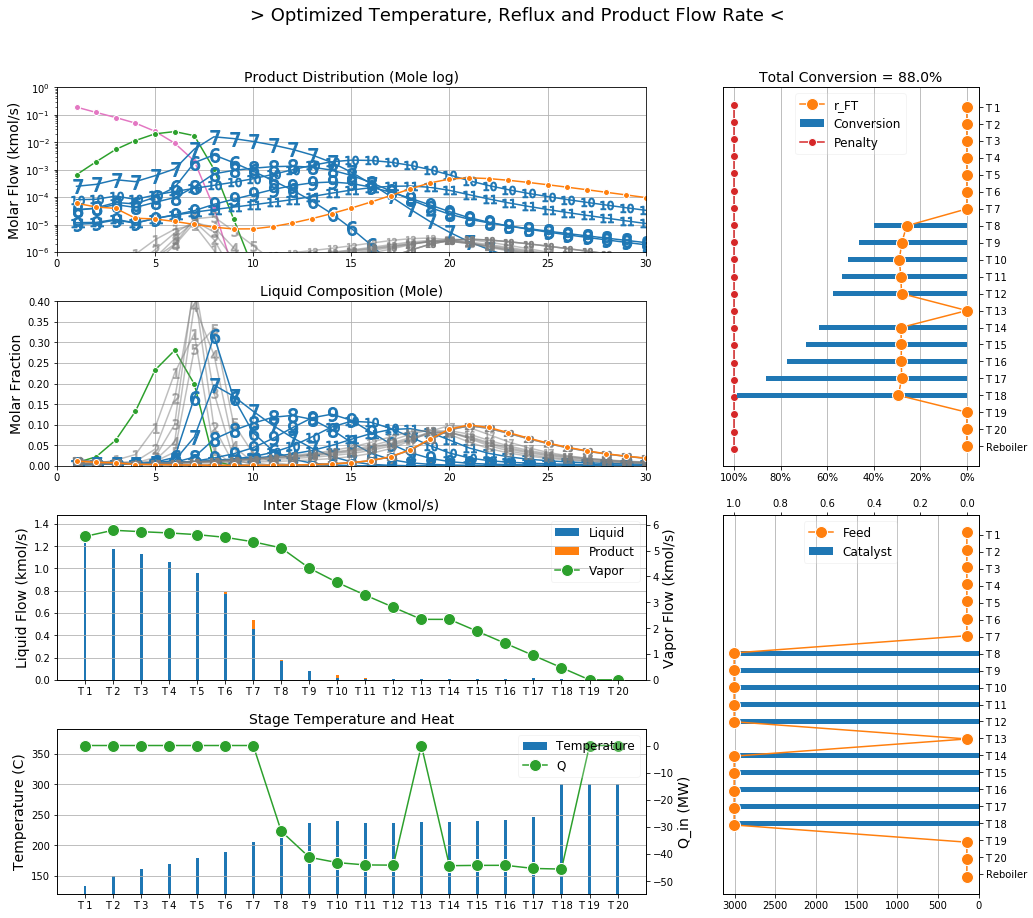

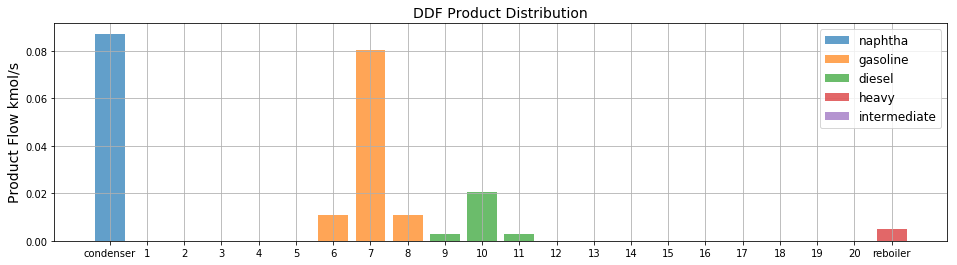

In [25]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [26]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [27]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [28]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Gasoline Location')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     # check_iteration()

# plot_distribution(model,pdf,'Optimized Gasoline Location')
# plot_product_distribution(model,pdf)

In [29]:
# master_model = deepcopy(model)

In [30]:
# model = deepcopy(master_model)

In [31]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(7)
model.N_tray['diesel'].setub(20)

In [32]:
# while True:
#     iter_count += 2
#     total_iter += 2
#     opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = False)
#     model_tmp = deepcopy(model)
#     results = opt.solve(model_tmp,tee=False)

#     for i in meta_results.keys():
#         if i != 'iter_count' and i != 'total_iter':
#             meta_results[i].append(model_tmp.find_component(i).value)
#     meta_results['iter_count'].append(iter_count)
#     meta_results['total_iter'].append(total_iter)
    
#     print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
#     if results.solver.termination_condition.key == 'optimal':
#         break
        
# iter_count = 0
# model = deepcopy(model_tmp)

In [33]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma97                  yes
                   linear_system_scaling = none                  yes
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                               ma97_umax = 0.5                   yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20  

  56 -1.0939549e-01 1.37e+00 3.57e+02  -6.0 3.03e+02    -  4.12e-01 6.88e-01h  1
  57 -1.0935799e-01 1.37e-02 1.85e+06  -6.0 2.31e+01    -  6.14e-03 1.00e+00h  1
  58 -1.0935078e-01 3.31e-04 6.86e+01  -6.0 4.51e+00    -  1.00e+00 1.00e+00h  1
  59 -1.0932662e-01 5.17e-02 1.27e-01  -6.0 4.74e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.0932403e-01 1.86e-04 5.95e-04  -6.0 2.80e+00    -  1.00e+00 1.00e+00h  1
  61 -1.0932404e-01 3.58e-09 1.25e-09  -6.0 5.71e-03    -  1.00e+00 1.00e+00h  1
  62 -1.0962998e-01 4.68e-01 1.18e+02  -7.5 1.88e+02    -  4.84e-01 8.95e-01f  1
  63 -1.0954861e-01 1.65e-01 1.46e+02  -7.5 8.31e+01    -  1.66e-02 9.68e-01h  1
  64 -1.0953798e-01 2.18e-02 3.52e+01  -7.5 3.04e+01    -  7.69e-01 1.00e+00h  1
  65 -1.0953626e-01 2.09e-03 7.90e-03  -7.5 9.43e+00    -  1.00e+00 1.00e+00h  1
  66 -1.0953601e-01 1.96e-05 4.30e-05  -7.5 9.13e-01    -  1.00e+00 1.00e+00h  1
  67 -1.0953601e-01 2.83e-10


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 87.74%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -154.                                        2.0987          0.8402  0.0820       2.3344

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     128.5  0.000       0.000  0.000  0.000  0.000       5.3555  0.0000  1.0040  0.0000       20.000
NON--[2]     142.5  0.000       0.000  0.000  0.000  0.000       5.5193  0.0000  0.9182  0.0000       20.000
NON--[3]     154.4  0.000       0.000  0.000  0.000  0.000       5.4335  0.0000  0.8276  0.0000       20.000
NON--[4]     166.8  0.000       0.000  0.000  0.00

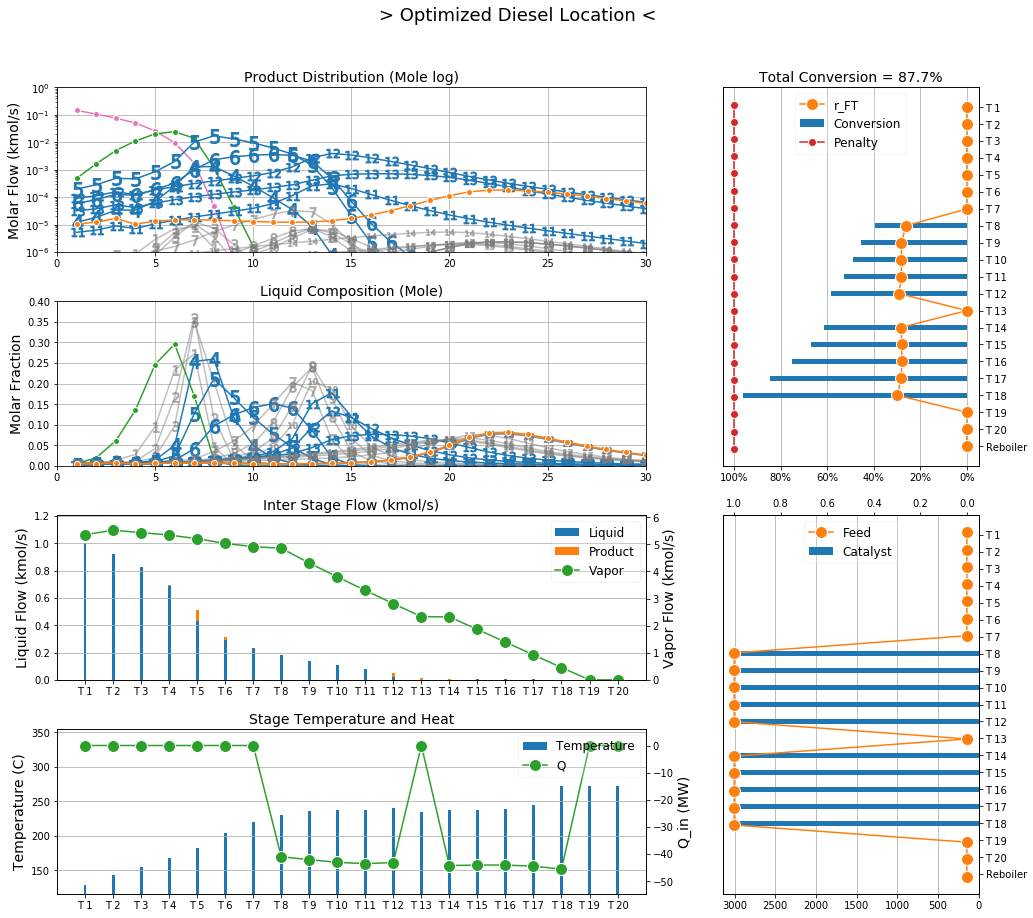

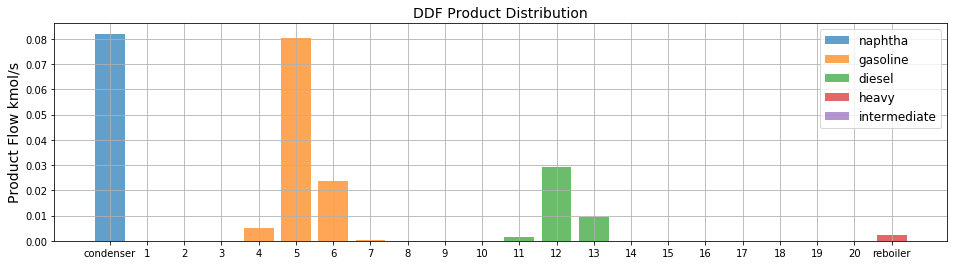

In [34]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [35]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [36]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(1e-5)
    model.reactive[j].F.setub(10)
    
# soft constraints to guide the feed allocation pattern
# model.reactive[17].F.setlb(3)

In [37]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [38]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Feed Allocation')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     check_iteration()

# plot_distribution(model,pdf,'Optimized Feed Allocation')
# plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [39]:
for j in model.TRAY_reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(10)
    model.reactive[j].cat.setub(30000)

In [40]:
model.total_cat_con = pe.ConstraintList()
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [41]:
# while True:
#     iter_count += 2
#     total_iter += 2
#     opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = False)
#     model_tmp = deepcopy(model)
#     results = opt.solve(model_tmp,tee=False)

#     for i in meta_results.keys():
#         if i != 'iter_count' and i != 'total_iter':
#             meta_results[i].append(model_tmp.find_component(i).value)
#     meta_results['iter_count'].append(iter_count)
#     meta_results['total_iter'].append(total_iter)
    
#     print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
#     if results.solver.termination_condition.key == 'optimal':
#         break
        
# iter_count = 0
# model = deepcopy(model_tmp)

In [42]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma97                  yes
                   linear_system_scaling = none                  yes
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                               ma97_umax = 0.5                   yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20  

  55 -1.2311229e-01 4.31e-01 2.47e+02  -6.0 5.38e+03  -9.5 1.07e-01 4.18e-02h  1
  56 -1.2321386e-01 4.25e-01 2.13e+02  -6.0 7.70e+02  -9.0 1.13e-01 1.32e-01h  1
  57 -1.2377949e-01 1.50e+00 1.77e+02  -6.0 1.55e+03  -9.5 2.28e-01 1.78e-01h  1
  58 -1.2382753e-01 1.44e+00 1.70e+02  -6.0 4.92e+02  -9.1 4.18e-02 4.32e-02h  1
  59 -1.2465090e-01 2.36e+00 1.27e+02  -6.0 1.85e+03  -9.6 1.44e-01 2.36e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.2556355e-01 2.75e+00 9.32e+01  -6.0 6.23e+02  -9.1 2.58e-01 7.31e-01h  1
  61 -1.2688984e-01 8.27e+00 6.55e+01  -6.0 3.58e+03  -9.6 6.44e-02 2.95e-01h  1
  62 -1.2769253e-01 6.69e+00 9.05e+01  -6.0 1.18e+03  -9.2 2.63e-01 3.25e-01h  1
  63 -1.2865277e-01 7.32e+00 6.50e+01  -6.0 2.98e+03  -9.7 2.27e-01 1.51e-01h  1
  64 -1.2889948e-01 6.51e+00 6.27e+01  -6.0 6.36e+02  -9.2 1.76e-01 1.09e-01h  1
  65 -1.3061501e-01 2.16e+01 7.96e+01  -6.0 7.64e+03  -9.7 1.49e-01 1.19e-01h  1
  66 -1.3096511e-01 2.07e+01

 146 -1.3943647e-01 9.14e+00 8.47e+04  -7.5 1.85e+00  -6.0 5.30e-01 6.71e-02h  1
 147 -1.3944156e-01 6.93e+00 6.42e+04  -7.5 5.78e+01    -  6.84e-01 2.41e-01h  1
 148 -1.3944842e-01 3.86e+00 3.57e+04  -7.5 5.10e+01    -  1.75e-01 4.44e-01h  1
 149 -1.3946942e-01 4.14e-01 6.47e+01  -7.5 7.94e+01    -  7.63e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -1.3946211e-01 1.51e-04 4.90e-02  -7.5 6.58e-01  -6.4 1.00e+00 1.00e+00h  1
 151 -1.3947118e-01 2.12e+01 6.99e-01  -7.5 3.80e+04    -  6.64e-02 3.30e-02h  1
 152 -1.3947116e-01 5.97e+00 1.16e-01  -7.5 4.84e-01  -6.9 1.00e+00 7.19e-01h  1
 153 -1.3948733e-01 7.27e+01 4.52e-01  -7.5 1.95e+04    -  1.34e-01 1.17e-01h  1
 154 -1.3949427e-01 4.04e+00 9.72e+02  -7.5 4.65e+02    -  2.94e-01 1.00e+00h  1
 155 -1.3949419e-01 3.95e+00 1.26e+03  -7.5 4.00e+00  -7.4 1.00e+00 2.12e-02h  1
 156 -1.3949143e-01 6.41e-03 1.56e+01  -7.5 8.96e+00  -7.9 7.84e-01 1.00e+00h  1
 157 -1.3949321e-01 9.84e-01


> Optimized Catalyst Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 90.00%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -148.                                        1.7284          0.6052  0.0815       2.4652

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.4  0.000       0.000  0.000  0.000  0.000       4.8805  0.0000  0.6991  0.0000       20.000
NON--[2]     131.0  0.000       0.000  0.000  0.000  0.000       4.9744  0.0000  0.6287  0.0000       20.000
NON--[3]     140.0  0.000       0.000  0.000  0.000  0.000       4.9040  0.0000  0.5575  0.0000       20.000
NON--[4]     150.7  0.000       0.000

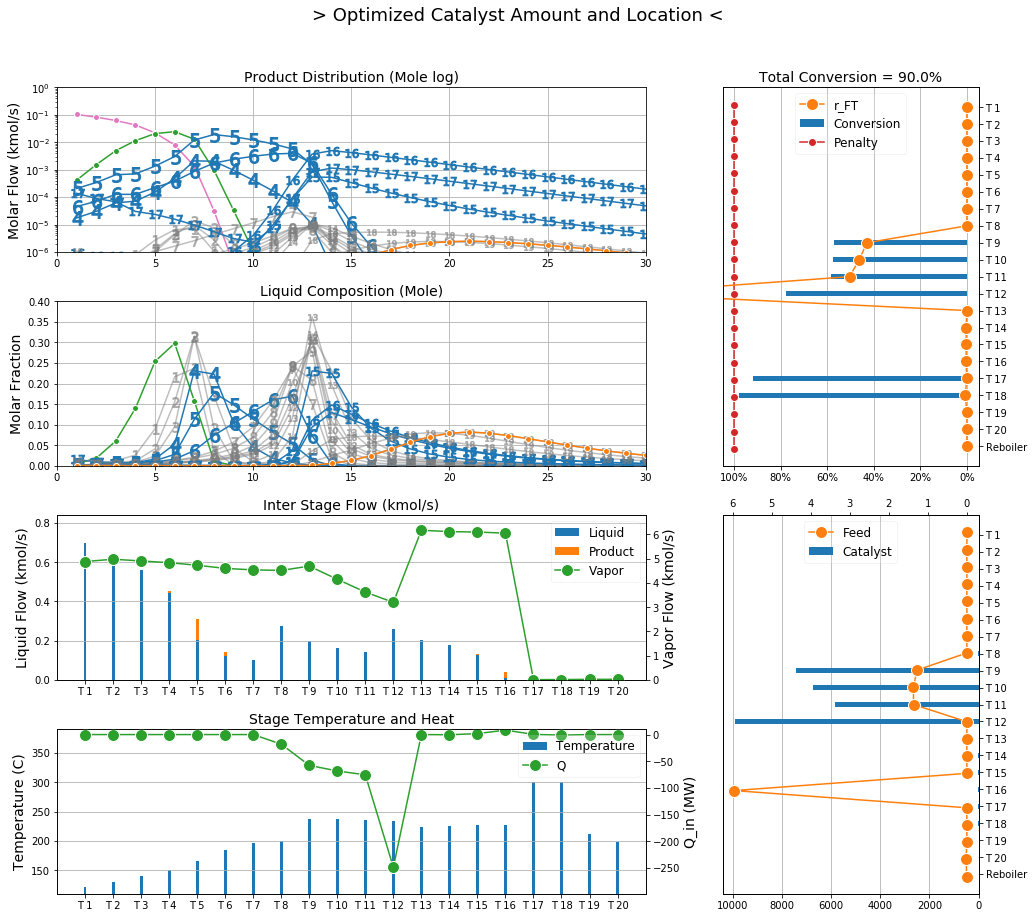

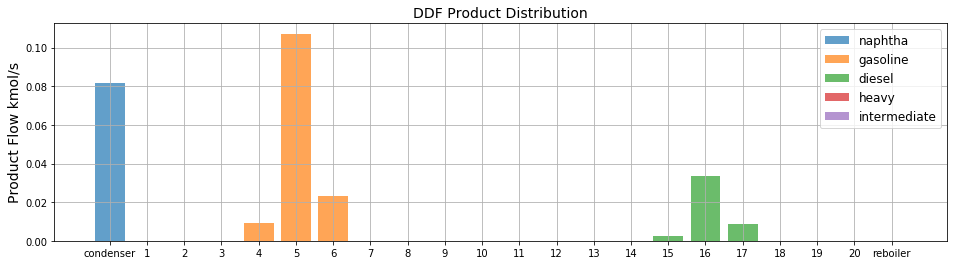

In [43]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Catalyst Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
plot_product_distribution(model,pdf)

In [44]:
pdf.close()

In [ ]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)

In [ ]:
with open('./log/results/{}.pickle'.format(logname),'wb') as f:
    pickle.dump(meta_results,f,protocol=pickle.HIGHEST_PROTOCOL)